In [3]:
#!/usr/bin/env python
# Copyright (c) Facebook, Inc. and its affiliates.
import argparse
import os
from itertools import chain
import cv2
import tqdm

os.chdir('/mnt/sdb1/lost+found/clones/MaskFormer-BDD100K')

from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data.build import filter_images_with_few_keypoints
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

# MaskFormer
from mask_former.data.datasets import register_bdd100k_sem_seg
from mask_former import MaskFormerSemanticDatasetMapper, add_mask_former_config

from matplotlib import pyplot as plt
%matplotlib inline

def setup(args):
    cfg = get_cfg()
    add_mask_former_config(cfg)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.DATALOADER.NUM_WORKERS = 0
    cfg.freeze()
    return cfg


def parse_args(in_args=None):
    parser = argparse.ArgumentParser(description="Visualize ground-truth data")
    parser.add_argument(
        "--source",
        choices=["annotation", "dataloader"],
        required=True,
        help="visualize the annotations or the data loader (with pre-processing)",
    )
    parser.add_argument("--config-file", metavar="FILE", help="path to config file")
    parser.add_argument("--output-dir", default="./", help="path to output directory")
    parser.add_argument("--show", action="store_true", help="show output in a window")
    parser.add_argument(
        "opts",
        help="Modify config options using the command-line",
        default=None,
        nargs=argparse.REMAINDER,
    )
    return parser.parse_args(in_args)

[10/22 12:57:51 detectron2]: Arguments: Namespace(config_file='configs/bdd100k-sem-seg/Vis-BDD100K-SEM-SEG-19.yaml', opts=[], output_dir='output3', show=True, source='annotation')


Loading config configs/bdd100k-sem-seg/Vis-BDD100K-SEM-SEG-19.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[10/22 12:57:51 d2.data.datasets.coco]: Loaded 7000 images with semantic segmentation from datasets/bdd100k_sem_seg/images_detectron2/train


  0%|                                                         | 0/16 [00:00<?, ?it/s]

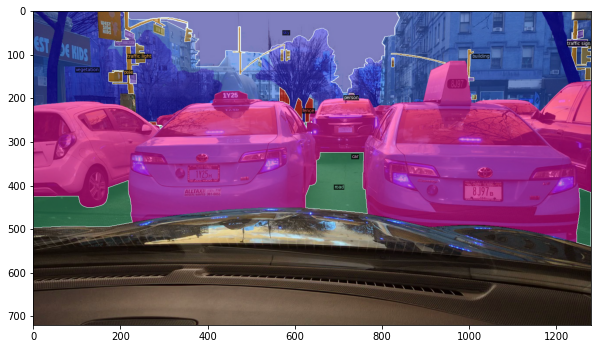

  6%|███                                              | 1/16 [00:00<00:12,  1.16it/s]

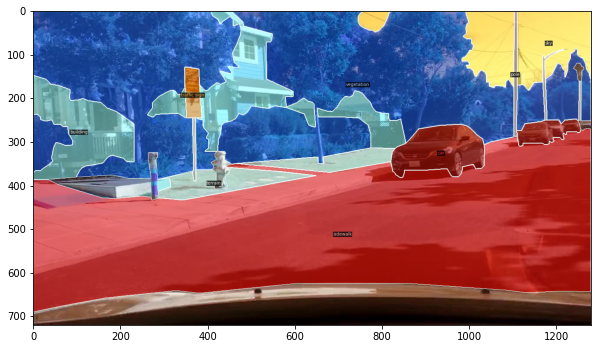

 12%|██████▏                                          | 2/16 [00:01<00:08,  1.58it/s]

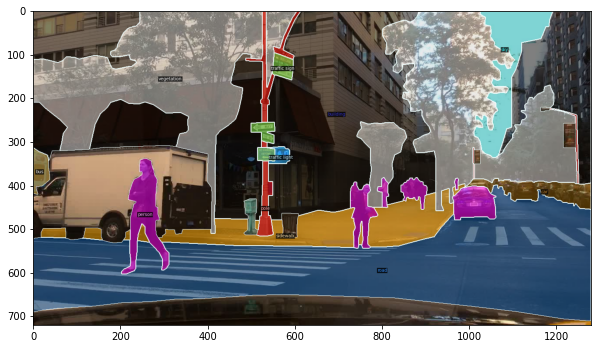

 19%|█████████▏                                       | 3/16 [00:01<00:07,  1.69it/s]

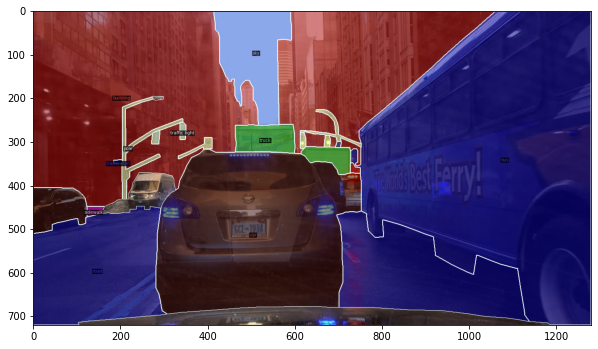

 25%|████████████▎                                    | 4/16 [00:02<00:06,  1.83it/s]

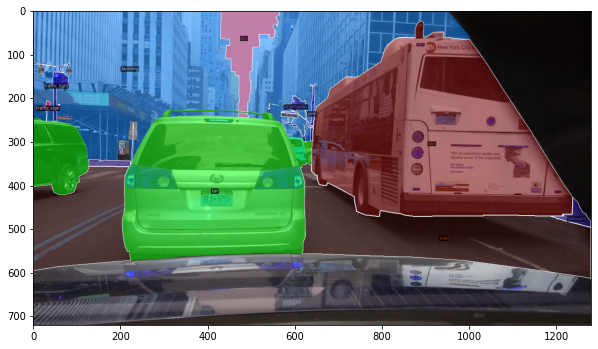

 31%|███████████████▎                                 | 5/16 [00:03<00:06,  1.69it/s]

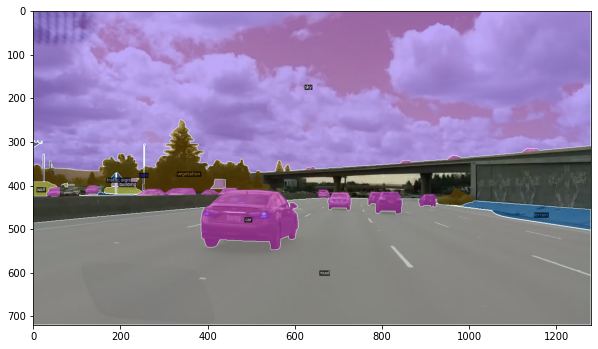

 38%|██████████████████▍                              | 6/16 [00:03<00:06,  1.63it/s]

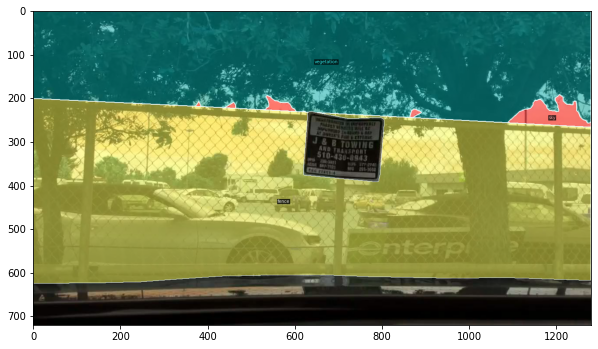

 44%|█████████████████████▍                           | 7/16 [00:04<00:04,  1.81it/s]

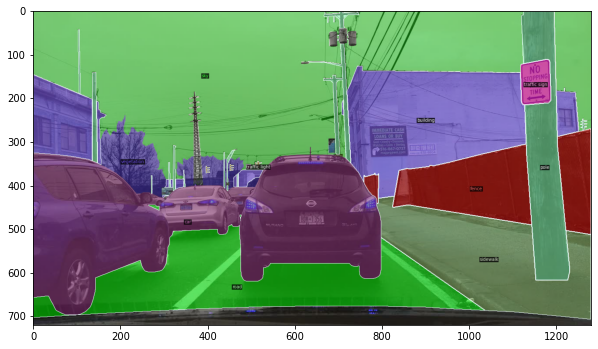

 50%|████████████████████████▌                        | 8/16 [00:04<00:05,  1.59it/s]

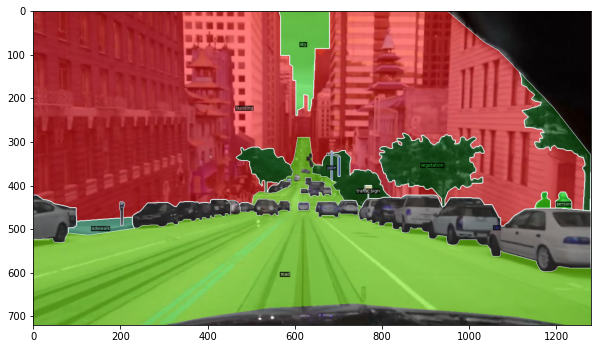

 56%|███████████████████████████▌                     | 9/16 [00:05<00:04,  1.63it/s]

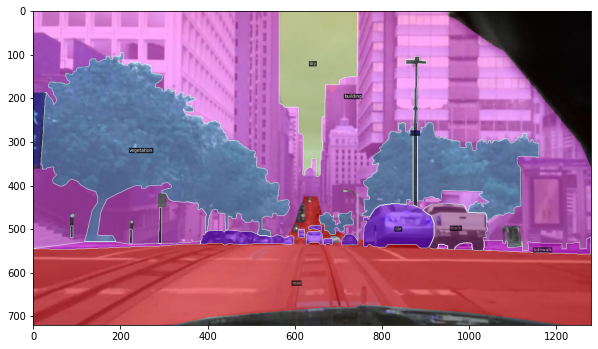

 62%|██████████████████████████████                  | 10/16 [00:06<00:03,  1.54it/s]

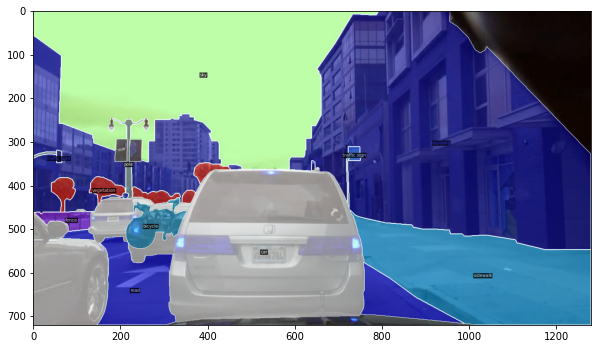

 69%|█████████████████████████████████               | 11/16 [00:06<00:03,  1.62it/s]

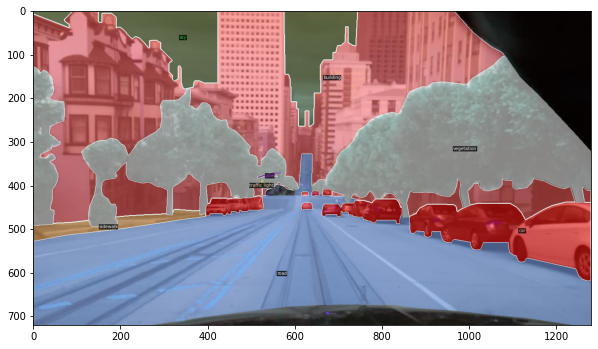

 75%|████████████████████████████████████            | 12/16 [00:07<00:02,  1.60it/s]

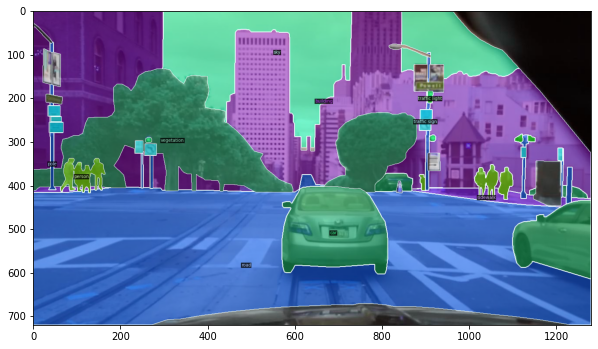

 81%|███████████████████████████████████████         | 13/16 [00:07<00:01,  1.63it/s]

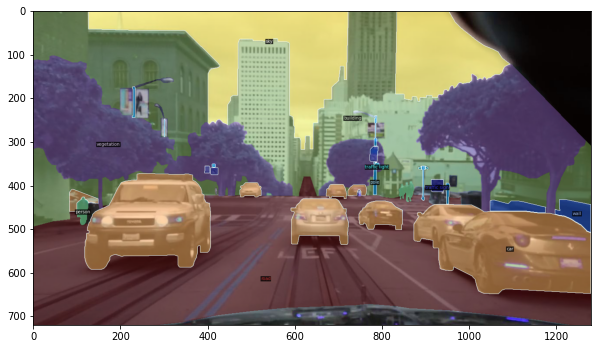

 88%|██████████████████████████████████████████      | 14/16 [00:08<00:01,  1.43it/s]

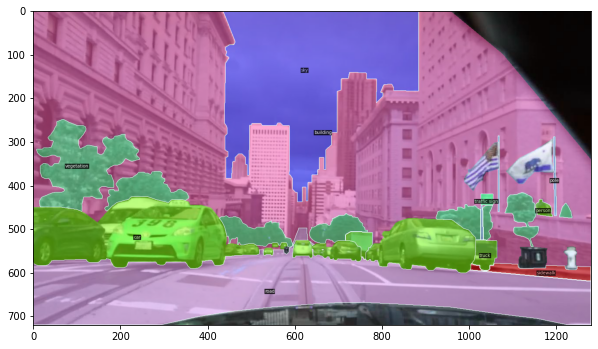

 94%|█████████████████████████████████████████████   | 15/16 [00:09<00:00,  1.44it/s]

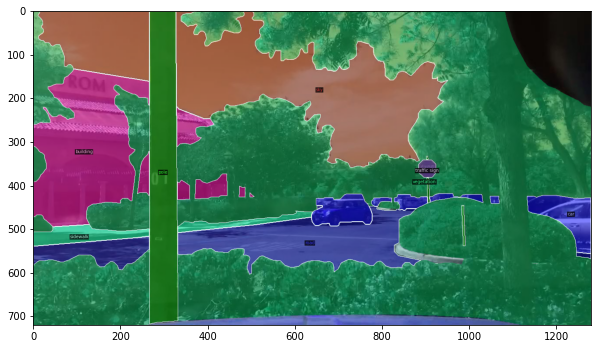

100%|████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


In [4]:
args = parse_args(in_args=[
    '--source','annotation',
    '--config-file','configs/bdd100k-sem-seg/Vis-BDD100K-SEM-SEG-19.yaml',
    '--output', 'output3',
    '--show'])
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup(args)

dirname = args.output_dir
os.makedirs(dirname, exist_ok=True)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

def output(vis, fname):
    if args.show:
        plt.figure(figsize = (10, 8))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()
    else:
        filepath = os.path.join(dirname, fname)
        print("Saving to {} ...".format(filepath))
        vis.save(filepath)

scale = 1.0
if args.source == "dataloader":
    
    # Semantic segmentation dataset mapper
    if cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_semantic":
        mapper = MaskFormerSemanticDatasetMapper(cfg, True)

    train_data_loader = build_detection_train_loader(cfg, mapper)
    i = 0
    for batch in train_data_loader:
        # AspectRatioGroupedDataset cannot get item, so break and stop
        if i > 0:
            break
        for per_image in batch:
            # Pytorch tensor is in (C, H, W) format
            img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
            img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

            visualizer = Visualizer(img, metadata=metadata, scale=scale)
            target_fields = per_image["instances"].get_fields()
            labels = [metadata.stuff_classes[i] for i in target_fields["gt_classes"]]
            vis = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            output(vis, str(per_image["file_name"]))
        i+=1
else:
    dicts = list(chain.from_iterable([DatasetCatalog.get(k) for k in cfg.DATASETS.TRAIN]))
    for dic in tqdm.tqdm(dicts[0:cfg.SOLVER.IMS_PER_BATCH]):
        img = utils.read_image(dic["file_name"], "RGB")
        visualizer = Visualizer(img, metadata=metadata, scale=scale)
        vis = visualizer.draw_dataset_dict(dic)
        output(vis, os.path.basename(dic["file_name"]))